!pip install imutils

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import cv2
from skimage import color

import torch
import torch.nn as nn

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import imutils
from imutils.video import VideoStream

np.random.seed(42)

## Model

In [2]:
def double_convs(in_channels, out_channels):
    conv_layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

    return conv_layers

def expansion_block(upsample_layer, conv_layer, inp, concat_inp):
    mask = upsample_layer(inp)
    mask = torch.concat([concat_inp, mask], dim=1)
    mask = conv_layer(mask)

    return mask


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #contraction path
        self.contrac1 = double_convs(in_channels, 64)
        self.contrac2 = double_convs(64, 128)
        self.contrac3 = double_convs(128, 256)
        self.contrac4 = double_convs(256, 512)
        self.contrac5 = double_convs(512, 1024)

        #expansion path
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.double_conv1 = double_convs(1024, 512)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.double_conv2 = double_convs(512, 256)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.double_conv3 = double_convs(256, 128)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.double_conv4 = double_convs(128, 64)

        #output layer
        self.out = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.Conv2d(64, out_channels, kernel_size=1)
            )

    def forward(self, image):
        #contraction
        cntrc_out1 = self.contrac1(image) #->
        out1 = self.max_pool(cntrc_out1)
        
        cntrc_out2 = self.contrac2(out1) #->
        out2 = self.max_pool(cntrc_out2)

        cntrc_out3 = self.contrac3(out2) #->
        out3 = self.max_pool(cntrc_out3)

        cntrc_out4 = self.contrac4(out3) #->
        out4 = self.max_pool(cntrc_out4)

        cntrc_out5 = self.contrac5(out4)

        #expansion
        mask = expansion_block(self.upsample1, self.double_conv1, cntrc_out5, cntrc_out4)
        mask = expansion_block(self.upsample2, self.double_conv2, mask, cntrc_out3)
        mask = expansion_block(self.upsample3, self.double_conv3, mask, cntrc_out2)
        mask = expansion_block(self.upsample4, self.double_conv4, mask, cntrc_out1)

        #output
        output = self.out(mask)

        return output

In [3]:
model = UNet(3, 22)

In [4]:
checkpoint = torch.load("../model/model.pt", map_location="cpu")
model_state = checkpoint['model_state_dict']

In [5]:
model.load_state_dict(model_state)

<All keys matched successfully>

## Transforming Inputs and Outputs

In [6]:
class config:
    N_COLORS = 22
    COLORS = cm.plasma(np.random.uniform(size = N_COLORS))
    MODEL = model

In [7]:
config.COLORS

array([[0.660374, 0.134144, 0.588971, 1.      ],
       [0.968443, 0.894564, 0.147014, 1.      ],
       [0.965024, 0.559118, 0.268513, 1.      ],
       [0.881443, 0.392529, 0.383229, 1.      ],
       [0.343925, 0.004991, 0.64471 , 1.      ],
       [0.343925, 0.004991, 0.64471 , 1.      ],
       [0.17895 , 0.019252, 0.584054, 1.      ],
       [0.994141, 0.753137, 0.161404, 1.      ],
       [0.881443, 0.392529, 0.383229, 1.      ],
       [0.953428, 0.52796 , 0.288883, 1.      ],
       [0.10598 , 0.024309, 0.551368, 1.      ],
       [0.956808, 0.928152, 0.152409, 1.      ],
       [0.993814, 0.704741, 0.183043, 1.      ],
       [0.435734, 0.001127, 0.659797, 1.      ],
       [0.387183, 0.001434, 0.654177, 1.      ],
       [0.387183, 0.001434, 0.654177, 1.      ],
       [0.568201, 0.055778, 0.639477, 1.      ],
       [0.819651, 0.306812, 0.448306, 1.      ],
       [0.72767 , 0.200586, 0.535293, 1.      ],
       [0.551715, 0.043136, 0.645277, 1.      ],
       [0.89034 , 0.

In [7]:
def transform_inputs(image):
    transforms = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
    ])
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    trnsfrmd = transforms(image=image)

    image = trnsfrmd['image']
    
    return image

In [8]:
def get_output(model, image):
    image = image.unsqueeze(0)
    
    logits = model(image.float())
    probs = logits.softmax(axis=1)
    probs = probs[0]
    pred = torch.argmax(probs, axis=0)
    pred *= 10
    
    return pred.numpy()

In [10]:
def get_results(frame):
    md_input = transform_inputs(frame)
    
    pred_mask = get_output(config.MODEL, md_input)
    
    md_input = md_input.permute(1,2,0).numpy()
    
    result_image = color.label2rgb(pred_mask, md_input, colors=config.COLORS)
    
    return result_image

## OpenCV: Real-Time Parsing

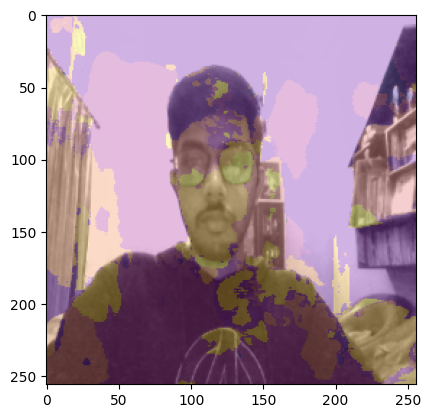

In [11]:
vs = VideoStream(src=0).start()

while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    
    results = get_results(frame)
    
    #result_image = result_image.astype(np.uint8)
    plt.imshow(results)
    
    cv2.namedWindow("Drving Scene Parsing", cv2.WINDOW_NORMAL)
  
    # Using resizeWindow()
    cv2.resizeWindow("Drving Scene Parsing", 600, 500)

    cv2.imshow("Drving Scene Parsing", results)
    key = cv2.waitKey(1) & 0xFF

    # if the `esc` key was pressed, break from the loop
    if key == 27:
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()